In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Обработка результатов

## **Изучение полученных результатов из УМ**

In [43]:
def get_result(config:str,way_type:str,fault:str,speed:int,profile:str = "gost") ->pd.DataFrame:
    """
    Получение результатов расчетов по ключевым словам
    1. `config` принимает два вида строк `empty` и `loaded`
    2. `way_type` принимает три вида строк `straight`, `curve_350` и `curve_650`
    3. `fault` принимает три вида строк `normal`, `polzun15`, `ellips10`
    4. `speed` от 10 до 60 км/ч
    5. `profile` есть профили `gost`, `newwagonw`, `greb_26`, `greb_30`, `greb_28`
    """
    if config == "empty":
        PATH = "C:\\Users\\Daniil\\Desktop\\simulation_results\\empty"
    
    elif config == "loaded":
        PATH = "C:\\Users\\Daniil\\Desktop\\simulation_results\\loaded"
    
    name = "\\"+config+"_"+way_type+"_"+fault+"_"+str(speed)+"_"+profile+".csv"

    l_name = len(name)

    FULL_PATH = PATH+name

    file = pd.read_csv(FULL_PATH,encoding='latin-1')

    COL_NAMES = ["time_step",name[1:l_name-4]]

    file.columns = COL_NAMES

    file = file.set_index("time_step")
    
    return file


In [38]:
def get_profile_results(config:str,way_type:str,fault:str,speed:int):
    file1 = get_result(config, way_type,fault,speed)
    file2 = get_result(config, way_type,fault,speed, "greb_26")
    file3 = get_result(config, way_type,fault,speed, "greb_28")
    file4 = get_result(config, way_type,fault,speed, "greb_30")
    file5 = get_result(config, way_type,fault,speed, "newwagonw")

    return file1,file2,file3,file4,file5

In [39]:
def plot_profile_results(config:str,way_type:str,fault:str,speed:int):
    
    d={"loaded":"Груженый",
       "empty":"Порожний",
       "straight":"прямая",
       "curve_350":"кривая 350 м",
       "curve_650":"кривая 650 м",
       "normal":"без неисправностей",
       "polzun15":"ползун",
       "ellips10":"неравномерный прокат"}
    
   #  sns.set (rc={' axes.facecolor':'#C0C0C0', 'figure.facecolor':'#FFFFF0 '})
    
    files = get_profile_results(config, way_type,fault,speed)
    FILE = pd.concat(files,axis=1)
    FILE.columns = ["gost","greb_26","greb_28","greb_30","newwagonw"]

    plt.figure(figsize=(12,8))
    sns.lineplot(FILE)
    plt.title(f"{d[config]} вагон, {d[way_type]}, {d[fault]} скорость {speed} км/ч ")
    plt.xlabel("Время, с")
    plt.ylabel("Вертикальная сила, Н")
    plt.show()



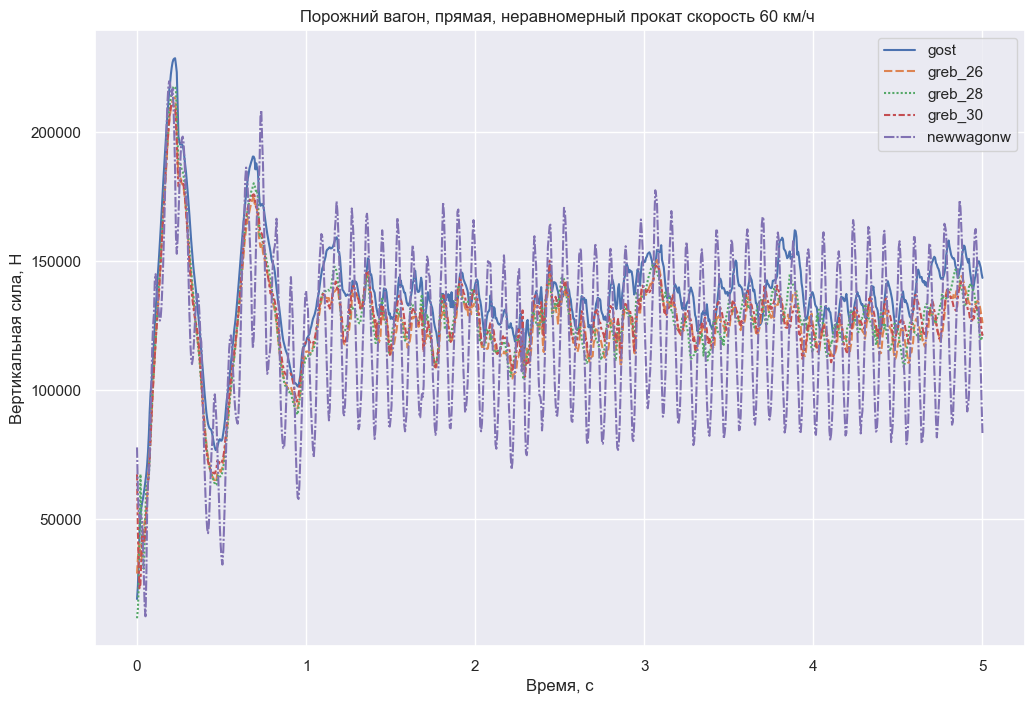

In [15]:
plot_profile_results("empty","straight","ellips10",60)

In [44]:
empty_straight_normal_10 = get_result("empty","straight","normal",10)
empty_straight_normal_10.head()

,empty_straight_normal_10_gost
time_step,
0.000000,29575.992
0.005109,32467.777
0.010109,35095.023
0.015109,38440.480
0.020109,41884.520


In [46]:
empty_straight_normal_10.columns[0]

'empty_straight_normal_10_gost'

## **Подготовка инфы для разделения на кастомные фолды**

Так как колесо по ГОСТ имеет радиус 475 мм, то полный оборот колеса fold = 2*pi*475

Тогда время прохождения полного оборота колеса будет равно t = fold/v 

In [35]:
def time_split(v:int) -> int:
    """Определение временного промежутка полного оборота колеса
    1. v - скорость движения поезда, км/ч
    """
    speed = v/3.6
    lenght = 2*np.pi*0.475
    t = lenght/speed
    return t

In [36]:
time_split(10)

1.0744246875277093

In [47]:
"empty_straight_normal_10".split("_")

['empty', 'straight', 'normal', '10']

In [ ]:
def get_time_splits(data:pd.DataFrame):
    start_point = 1.4

    time_max_point = data.index.max()               # Максимальное время

    col_name = data.columns[0].split("_")           # 10,20,30... км/ч

    wheel_rotate_num = time_split(int(col_name[3])) # 1.007

    num_folds = time_max_point//wheel_rotate_num    # Сколько всего фолдов получится сделать

    fold_1 = data[data>start_point]

    

**Описание данных фолдов**

<AxesSubplot: xlabel='time_step'>

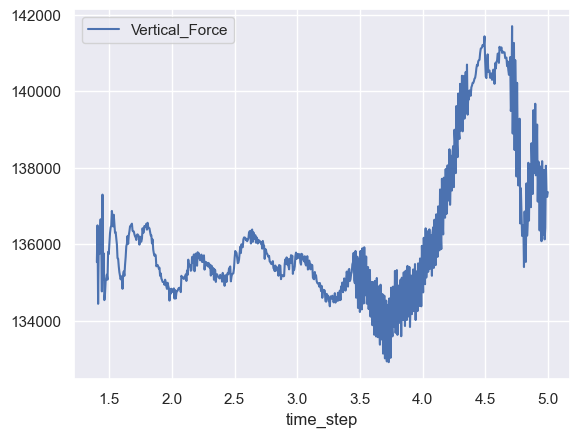

In [23]:
empty_straight_normal_10[empty_straight_normal_10.index > 1.4].plot()

In [26]:
brave_description = empty_straight_normal_10.describe().T

In [27]:
def get_min_max_delta(data:pd.DataFrame):
    max = data.max()
    min = data.min()
    return max-min

In [28]:
get_min_max_delta(empty_straight_normal_10)

Vertical_Force    199170.738
dtype: float64

In [ ]:
brave_description